In [1]:
import os

import matplotlib.pylab as plt
import numpy as np
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

In [2]:
from query_gaia import *

/Users/mbedell/python/TACS/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### validate parameters using Bedell+2018 solar twins:

In [65]:
if False:
    st_params = Table.read('/Users/mbedell/Documents/Papers/abundances-solartwins/data/final_parameters.csv')
    st = st_params[0:-1] # leave off the sun
    st['source_id'] = get_dr3_sources_from_simbad(st['id'])
    st_with_gaia = query_gaia_astrophysical_parameters(st)
    st_with_gaia.write('solartwins_with_gaia.csv')
    st = st_with_gaia
else:
    st = Table.read('solartwins_with_gaia.csv')

In [66]:
gspspec_corrected = st['logg_gspspec'] + 0.4496 - 0.0036*st['logg_gspspec'] - 0.0224*st['logg_gspspec']**2
gspmh_corrected = st['mh_gspspec'] + 0.274 - 0.1373*st['logg_gspspec'] - 0.0050*st['logg_gspspec']**2 + 0.0048*st['logg_gspspec']**3

In [67]:
def fit_a_line_noerr(x,y):
    A = np.vstack([x, np.ones(len(x))]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, b

from scipy.odr import ODR, Model, RealData

def linear_func(B, x):
    return B[0]*x + B[1]

def fit_a_line(x,y,sigma_x,sigma_y):
    linear_model = Model(linear_func)
    data = RealData(x, y, sx=sigma_x, sy=sigma_y)
    first_guess = fit_a_line_noerr(x,y)
    odr = ODR(data, linear_model, beta0=first_guess)
    output = odr.run()
    m, b = output.beta
    m_err, b_err = output.sd_beta
    return m,b

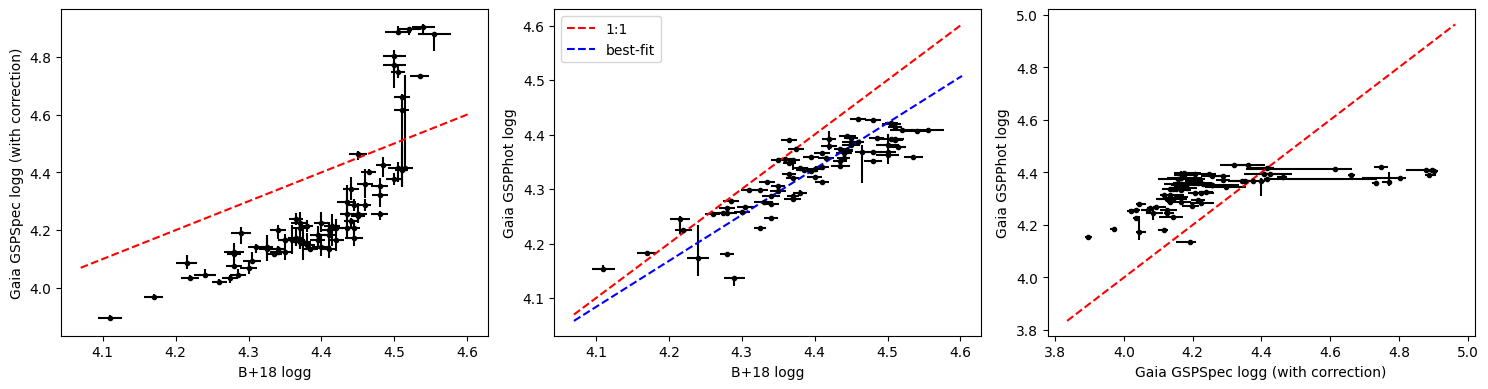

In [68]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['logg'], st['logg_gspspec'], xerr=st['err_logg'], 
                 yerr=[st['logg_gspspec']-st['logg_gspspec_lower'],st['logg_gspspec_upper']-st['logg_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+18 logg')
axes[0].set_ylabel('Gaia GSPSpec logg (with correction)')
#axes[0].legend()
axes[1].errorbar(st['logg'], st['logg_gspphot'], xerr=st['err_logg'], 
                 yerr=[st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--', label='1:1')
avg_err = np.mean([st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']])
m_logg,b_logg = fit_a_line(st['logg'], st['logg_gspphot'], st['err_logg'], avg_err)
axes[1].plot(xl, m_logg*np.array(xl)+b_logg, 'b--', label='best-fit')
axes[1].set_xlabel('B+18 logg')
axes[1].set_ylabel('Gaia GSPPhot logg')
axes[1].legend()
axes[2].errorbar(gspspec_corrected, st['logg_gspphot'], 
             xerr=[st['logg_gspspec']-st['logg_gspspec_lower'],st['logg_gspspec_upper']-st['logg_gspspec']],
             yerr=[st['logg_gspphot']-st['logg_gspphot_lower'],st['logg_gspphot_upper']-st['logg_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec logg (with correction)')
axes[2].set_ylabel('Gaia GSPPhot logg')
fig.tight_layout()
fig.savefig('comparison_logg.png');

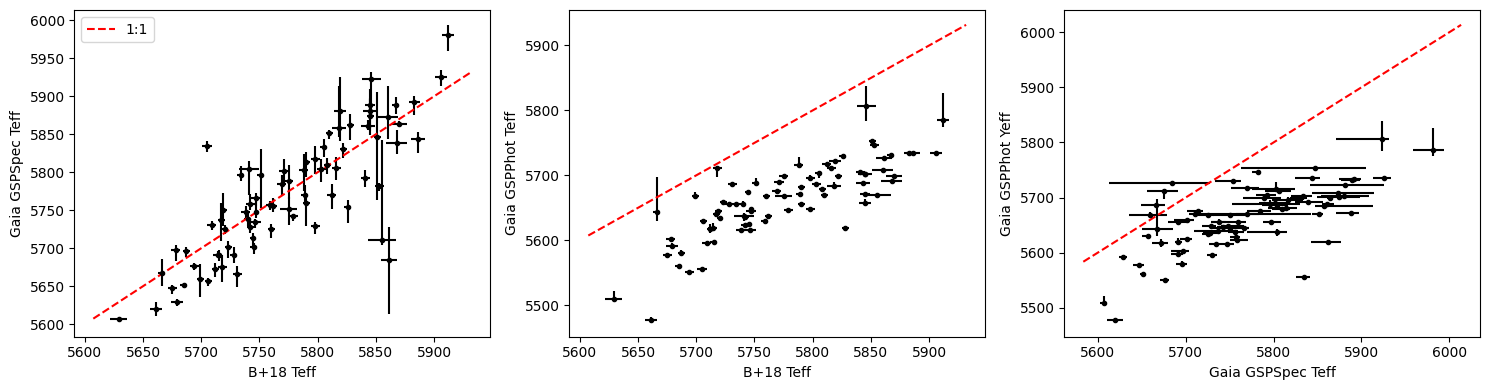

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['teff'], st['teff_gspspec'], xerr=st['err_teff'], 
                 yerr=[st['teff_gspspec']-st['teff_gspspec_lower'],st['teff_gspspec_upper']-st['teff_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
axes[0].set_xlabel('B+18 Teff')
axes[0].set_ylabel('Gaia GSPSpec Teff')
axes[0].legend()
axes[1].errorbar(st['teff'], st['teff_gspphot'], xerr=st['err_teff'], 
                 yerr=[st['teff_gspphot']-st['teff_gspphot_lower'],st['teff_gspphot_upper']-st['teff_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+18 Teff')
axes[1].set_ylabel('Gaia GSPPhot Teff')
axes[2].errorbar(st['teff_gspspec'], st['teff_gspphot'], 
             xerr=[st['teff_gspspec']-st['teff_gspspec_lower'],st['teff_gspspec_upper']-st['teff_gspspec']],
             yerr=[st['teff_gspphot']-st['teff_gspphot_lower'],st['teff_gspphot_upper']-st['teff_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec Teff')
axes[2].set_ylabel('Gaia GSPPhot Yeff')
fig.tight_layout()
fig.savefig('comparison_teff.png');

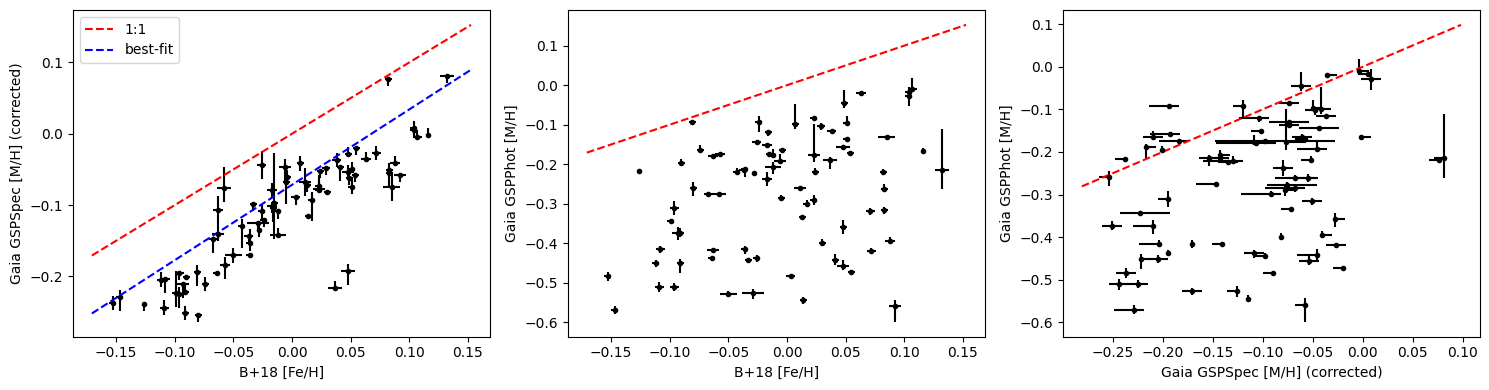

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].errorbar(st['feh'], gspmh_corrected, xerr=st['err_feh'], 
                 yerr=[st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']],
                 fmt='k.')
xl = axes[0].get_xlim()
axes[0].plot(xl, xl, 'r--', label='1:1')
avg_err = np.mean([st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']])
m_mh,b_mh = fit_a_line(st['feh'], st['mh_gspspec'], st['err_feh'], avg_err)
axes[0].plot(xl, m_mh*np.array(xl)+b_mh, 'b--', label='best-fit')
axes[0].set_xlabel('B+18 [Fe/H]')
axes[0].set_ylabel('Gaia GSPSpec [M/H] (corrected)')
axes[0].legend()
axes[1].errorbar(st['feh'], st['mh_gspphot'], xerr=st['err_feh'], 
                 yerr=[st['mh_gspphot']-st['mh_gspphot_lower'],st['mh_gspphot_upper']-st['mh_gspphot']],
                 fmt='k.')
xl = axes[1].get_xlim()
axes[1].plot(xl, xl, 'r--')
axes[1].set_xlabel('B+18 [Fe/H]')
axes[1].set_ylabel('Gaia GSPPhot [M/H]')
axes[2].errorbar(gspmh_corrected, st['mh_gspphot'], 
             xerr=[st['mh_gspspec']-st['mh_gspspec_lower'],st['mh_gspspec_upper']-st['mh_gspspec']],
             yerr=[st['mh_gspphot']-st['mh_gspphot_lower'],st['mh_gspphot_upper']-st['mh_gspphot']],
             fmt='k.')
xl = axes[2].get_xlim()
axes[2].plot(xl, xl, 'r--')
axes[2].set_xlabel('Gaia GSPSpec [M/H] (corrected)')
axes[2].set_ylabel('Gaia GSPPhot [M/H]')
fig.tight_layout()
fig.savefig('comparison_mh.png');

From these results, I conclude that GSPPhot logg and GSPSpec [M/H] should be used with a correction factor, and GSPSpec Teff can be used as-is.

### apply to gr8stars catalog:

In [92]:
if False:
    table = Table.read('Master_table.csv')
    source_ids = table['gaiaedr3_source_id']
    table_with_gaia = query_gaia_astrophysical_parameters(table, source_id_name='gaiaedr3_source_id')
    table_with_gaia.write('gr8_with_gspspec.csv')
else:
    table_with_gaia = Table.read('gr8_with_gspspec.csv')

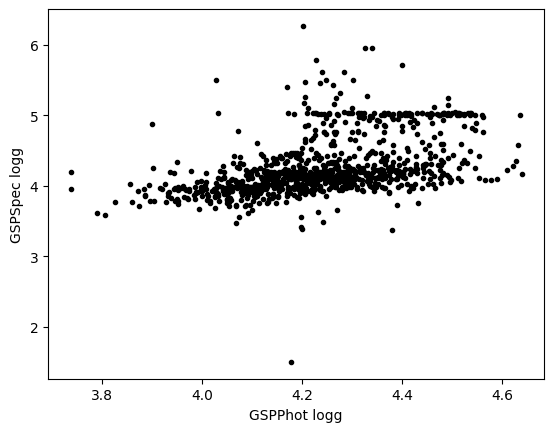

In [93]:
plt.plot(table_with_gaia['logg_gspphot'], table_with_gaia['logg_gspspec'], 'k.')
plt.xlabel('GSPPhot logg')
plt.ylabel('GSPSpec logg');

In [94]:
table_with_gaia['logg_gspphot_corrected'] = (table_with_gaia['logg_gspphot'] - b_logg) / m_logg
table_with_gaia['mh_gspspec_corrected'] = (table_with_gaia['mh_gspspec'] - b_mh) / m_mh

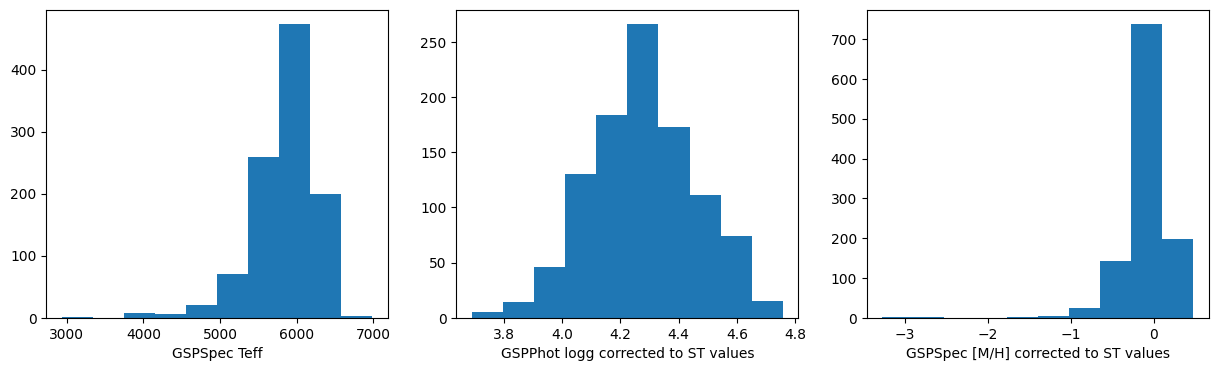

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].hist(table_with_gaia['teff_gspspec'])
axes[0].set_xlabel('GSPSpec Teff')
axes[1].hist(table_with_gaia['logg_gspphot_corrected'])
axes[1].set_xlabel('GSPPhot logg corrected to ST values')
axes[2].hist(table_with_gaia['mh_gspspec_corrected'])
axes[2].set_xlabel('GSPSpec [M/H] corrected to ST values');

In [97]:
#table_with_gaia[table_with_gaia['logg_gspphot'].mask]

In [85]:
# filter out 94 objects without gspphot loggs (why??):
table_with_gaia = table_with_gaia[np.logical_not(table_with_gaia['logg_gspphot'].mask).nonzero()]

In [99]:
filters = (table_with_gaia['NIGHTS'] > 240) & (np.abs(table_with_gaia['teff_gspspec'] - 5778.) <= 200) & \
          (np.abs(table_with_gaia['logg_gspphot_corrected'] - 4.44) <= 0.2) & \
          (np.abs(table_with_gaia['mh_gspspec_corrected']) <= 0.2)
table_with_gaia[filters].write('gr8_solartwins.csv', overwrite=True)

In [100]:
table_with_gaia[filters]

col0,ra_j2000,dec_j2000,primary_name,gaiaedr3_source_id,hip,hd,tic,parallax,pmra,pmdec,gmag,bp_rp,radial_velocity,spectrum_harps_1d,spectrum_harps_2d,spectrum_sophie_1d,spectrum_sophie_2d,Teff(K),Teff_err(K),logg,logg_err,Fe/H,Fe/H_err,alpha,alpha_err,vmic,vmic_err,vmac,vmac_err,vsini,vsini_err,Notes,w1mpro,w1sigmpro,w2mpro,w2sigmpro,w3mpro,w3sigmpro,j_m,j_msigcom,h_m,h_msigcom,k_m,k_msigcom,Bmag,e_Bmag,Vmag,e_Vmag,Mass,Mass-err,Mass+err,Radius,Radius-err,Radius+err,Age,Age-err,Age+err,MIST logg,MIST logg-err,MIST logg+err,Density,Density-err,density+err,MIST Teff,MIST Teff-err,MIST Teff+err,logLuminosity,logLuminosity-err,logLuminosity+err,deltanu,deltanu-err,deltanu+err,numax,numax-err,numax+err,Unnamed: 75,Unnamed: 76,Unnamed: 77,ra,dec,season_length,airmass_min,airmass_mean,tyr_rise,tyr_set,eff_nights,eff_airmass_mean,eff_seeing,nb_subexp,snr_550,snr_550_texp15,sig_rv_texp15,texp_snr_250,sig_rv_osc_texp15,sig_rv_osc+gr_texp15,HZ_period_inf,HZ_period_sup,HZ_amp_inf,HZ_amp_sup,HZ_mp_min_texp15,HZ_mp_min_osc_texp15,HZ_mp_min_osc+gr_texp15,NIGHTS,FIRST_NIGHT,LAST_NIGHT,ruwe,Teff_spec,Fe/H_spec,logg_spec,vsini_spec,Teff_phot,logRHK,Teff_gspphot,logg_gspphot,source_id,teff_gspspec,logg_gspspec,mh_gspspec,alphafe_gspspec,logg_gspphot_corrected,mh_gspspec_corrected
int64,float64,float64,str26,int64,float64,str7,int64,float64,float64,float64,float64,float64,float64,str4,str4,str4,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str10,str10,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
12,61.334408,22.008905,39Tau,53112944270520832,19076.0,25680,15736408,59.4728,172.212,-130.609,5.756682,0.803842,24.11,--,--,--,--,5884.76018543594,121.587398069069,4.54102057418332,0.166765590031718,0.104,0.0907257304196064,0.0,0.0,1.25951515556692,0.0539162274922259,4.58,0.0,3.68089281230984,1.01375287622754,--,4.36,0.244,4.203,0.147,4.432,0.015,4.907,0.238,4.499,0.036,4.381,0.042,6.523,0.017,5.903,0.017,1.04094177631552,-0.0392365893817448,0.0267275620578127,0.983307086072755,-0.0081800804769942,0.009651683733367,9.23216718027021,-0.481566494703632,0.335066633971554,4.47061768915576,-0.0217186740122468,0.0144732936905223,1.5463431841939,-0.0852663779997154,0.062980139241094,5833.54498761659,-78.0567880036488,77.4588965072353,0.0036214587838645,-0.0186554586305827,0.0181587806565891,148.198767383464,-3.86779745676429,2.73827960500807,3322.6059468224,-3.86779745676429,2.73827960500807,--,--,--,4.088960533333334,22.008905,259,1.0068361539313873,1.0610261189518029,2025.5657928730643,2026.240133021708,177.86121714397095,1.0657380104262746,0.939021554645485,2.0,409.0,578.0,0.1038,9.865005783087309,0.1155150445067355,0.2500638888300594,421.3031025565775,888.9382417334455,0.0648197006034179,0.0831379538247918,2.8005875424003954,3.116666614695478,6.746876800208687,241,2020-07-29,2020-03-25,0.947341,5884.76018543594,0.104,4.54102057418332,3.68089281230984,5770,--,5750.9917,4.4057,53112944270520832,5876.0,5.0,-0.12999999523162842,0.11999999731779099,4.481503073870269,-0.05529494517001603
14,58.023323,22.671633,HD24206,64085383120724864,18097.0,24206,440702883,33.5609,206.762,-339.42,7.400138,0.860472,11.23,--,--,True,True,5320.5235053406,103.24052883794,3.9596584020662,0.0764983855779542,0.0309999999999996,0.0853015559131887,0.0,0.0,0.429615456308443,0.067130